# Heartsteps Data Transformation

We transform the Heartsteps v1 data to satisfy two primary criterion: (1) alignment of study day and decision slot across users and (2) restructuring of the data to match the distributional nearest neighbors framework. More information about this structure can be found later in the notebook.


## Import libraries and load data

In [3]:
import pandas as pd
import numpy as np

The `jbsteps.csv` file contains step data for (roughly) every minute that trial partipants were wearing their Jawbone step tracker. We select the columns of interest and index the dataframe by the user index and the time that steps were recorded.

In [135]:
# load in the 5 minute observations
df_steps = pd.read_csv("jbsteps.csv")
df_steps = df_steps[["user.index", "steps.utime", "steps", "study.day.nogap"]]
df_steps["steps.utime"] = pd.to_datetime(df_steps["steps.utime"])
#creeate multi-index
df_steps = df_steps.set_index(['user.index', 'steps.utime'])

The `suggestions.csv` file contains data for each notification slot during all user trials. There are 5 notification slots per day.

In [137]:
df_suggestions = pd.read_csv("suggestions.csv")

C:\Users\Caleb\AppData\Local\Temp\ipykernel_2704\2861572030.py:1: DtypeWarning: Columns (21,22,38,39,46,47) have mixed types. Specify dtype option on import or set low_memory=False.
  df_suggestions = pd.read_csv("suggestions.csv")


We select the columns of interest and drop rows containing nan for crucial columns.

In [138]:
df_sugg_sel = df_suggestions[["user.index", 'decision.index.nogap', 'sugg.select.utime','sugg.decision.utime', 'sugg.select.slot', 'avail', 'send', 'send.active', 'send.sedentary']]
df_sugg_sel['sugg.decision.utime'] = pd.to_datetime(df_sugg_sel['sugg.decision.utime'])
df_sugg_sel = df_sugg_sel.dropna(subset=["sugg.decision.utime", "sugg.select.utime", "user.index"])
df_sugg_sel

C:\Users\Caleb\AppData\Local\Temp\ipykernel_2704\3018626082.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sugg_sel['sugg.decision.utime'] = pd.to_datetime(df_sugg_sel['sugg.decision.utime'])


,user.index,decision.index.nogap,sugg.select.utime,sugg.decision.utime,sugg.select.slot,avail,send,send.active,send.sedentary
0,1,0.0,2015-07-22 16:30:00,2015-07-22 16:31:53,2,True,True,False,True
1,1,1.0,2015-07-22 18:30:00,2015-07-22 18:32:10,3,True,True,True,False
2,1,2.0,2015-07-22 21:30:00,2015-07-22 21:31:48,4,True,False,False,False
3,1,3.0,2015-07-22 23:30:00,2015-07-22 23:31:50,5,True,True,False,True
4,1,4.0,2015-07-23 09:30:00,2015-07-23 09:31:31,1,True,False,False,False
...,...,...,...,...,...,...,...,...,...
8269,37,225.0,2016-01-26 00:02:00,2016-01-26 00:03:36,5,True,False,False,False
8270,37,226.0,2016-01-26 13:00:00,2016-01-26 13:01:04,1,False,False,False,False
8271,37,227.0,2016-01-26 16:26:00,2016-01-26 16:27:50,2,True,True,True,False
8272,37,228.0,2016-01-26 19:00:00,2016-01-26 19:02:09,3,True,True,False,True


Next, we group the step observations into 5 minute chunks. 

In [139]:
def get_mode(x):
  if len(pd.Series.mode(x) > 1):
    return pd.Series.mode(x, dropna=False)[0]
  else:
    return pd.Series.mode(x, dropna=False)

df_5min = df_steps.groupby([pd.Grouper(freq='5min', level = "steps.utime", label = "right"), 
pd.Grouper(level = "user.index")], sort = False).agg({'steps': 'sum', 'study.day.nogap': lambda x : get_mode(x)}).reset_index()
df_5min

,steps.utime,user.index,steps,study.day.nogap
0,2015-07-22 14:55:00,1,19,NaN
1,2015-07-22 15:00:00,1,163,NaN
2,2015-07-22 15:05:00,1,58,NaN
3,2015-07-22 15:10:00,1,2,NaN
4,2015-07-22 15:15:00,1,61,NaN
...,...,...,...,...
98524,2016-01-26 21:20:00,37,23,46.0
98525,2016-01-26 21:25:00,37,57,46.0
98526,2016-01-26 21:35:00,37,67,46.0
98527,2016-01-26 21:45:00,37,20,46.0


Now, we expand the time periods to include all times of day, not just the times that steps were measured.
This is necessary as step data collection often occured in spurts. This means that time periods in which a notification was sent may not be represented in the original data frame, making it difficult to merge `df_suggestions` and `df_5min`. Time periods where steps were not tracked are imputed with 0 steps. This may not accurately represent the user's real step count in that period, but it is a limitation imposed by the data. Future work may fold in the Google Steps tracking information, which is more complete but potentially inaccurate approximation of user step activity.

In [140]:
# fill out the 5 minute intervals between measurements
from datetime import date, timedelta
def reind_id(df_u):
    rng = pd.date_range(min(df_u.index.astype('datetime64[ns]')), max(df_u.index.astype('datetime64[ns]')) + timedelta(days = 1), 
    normalize = True, inclusive = "both", freq = "5T")
    rng = rng[rng.indexer_between_time('00:00', '23:55')]
    #print(rng)
    df_reind = df_u.reindex(rng)
    df_reind['user.index'] = df_reind['user.index'].ffill().bfill()
    df_reind['study.day.nogap'] = df_reind['study.day.nogap'].bfill().ffill()
    df_reind['steps'] = df_reind['steps'].fillna(0)
    return df_reind

df_5min_ind = df_5min.set_index('steps.utime')

df_expand5min = df_5min_ind.groupby('user.index', group_keys = False).apply(lambda df_u:reind_id(df_u))
df_expand5min = df_expand5min.reset_index(names = "steps.utime")

df_expand5min['user.index'] = df_expand5min['user.index'].astype("int64")
print(df_expand5min)

        

               steps.utime  user.index  steps  study.day.nogap
0      2015-07-22 00:00:00           1    0.0              0.0
1      2015-07-22 00:05:00           1    0.0              0.0
2      2015-07-22 00:10:00           1    0.0              0.0
3      2015-07-22 00:15:00           1    0.0              0.0
4      2015-07-22 00:20:00           1    0.0              0.0
...                    ...         ...    ...              ...
492512 2016-01-26 23:40:00          37    0.0             46.0
492513 2016-01-26 23:45:00          37    0.0             46.0
492514 2016-01-26 23:50:00          37    0.0             46.0
492515 2016-01-26 23:55:00          37    0.0             46.0
492516 2016-01-27 00:00:00          37    0.0             46.0

[492517 rows x 4 columns]


Next, we merge `df_sugg_sel` with `df_expand5min`. The merge will provide notification information for each decision slot. Notifications are grouped into the 5 minute block that occurs after the decision was made. For example, a decision made at 8:31:50 AM would be joined with the 8:35 AM time slot. 

In [141]:
# merge as of on steps.utime with the time of each notification time period. by = user.index, tolerance = pd.Timedelta("5min"), check for direction
df_merged = pd.merge_asof(
    df_expand5min.sort_values(by ='steps.utime'),
    df_sugg_sel.sort_values(by = 'sugg.decision.utime'),
    left_on="steps.utime",
    right_on="sugg.decision.utime",
    by="user.index",
    tolerance=pd.Timedelta("5min"),
    allow_exact_matches=False,
    direction = 'backward'
).sort_values(by = ["user.index", "steps.utime"]).reset_index(drop = True)

#df_merged[df_merged["user.index"] == 1][df_merged["sugg.select.utime"] == "2015-09-15 10:30:00"]
#with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    #display(df_merged[df_merged['user.index'] == 36][7000:7150])
    
# want to treat vacation days as maximally normal observation periods -> they are not notification periods
df_merged['sugg.select.slot'] = np.where(df_merged['decision.index.nogap'].isna(), np.nan, df_merged['sugg.select.slot'])
display(df_merged)

,steps.utime,user.index,steps,study.day.nogap,decision.index.nogap,sugg.select.utime,sugg.decision.utime,sugg.select.slot,avail,send,send.active,send.sedentary
0,2015-07-22 00:00:00,1,0.0,0.0,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN
1,2015-07-22 00:05:00,1,0.0,0.0,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN
2,2015-07-22 00:10:00,1,0.0,0.0,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN
3,2015-07-22 00:15:00,1,0.0,0.0,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN
4,2015-07-22 00:20:00,1,0.0,0.0,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
492512,2016-01-26 23:40:00,37,0.0,46.0,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN
492513,2016-01-26 23:45:00,37,0.0,46.0,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN
492514,2016-01-26 23:50:00,37,0.0,46.0,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN
492515,2016-01-26 23:55:00,37,0.0,46.0,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN


We take 12 rows after each decision period. This represents 1 hour of step data following each (potential) notification. We drop duplicate rows as some notifications fell within one hour of each other, creating overlapping time ranges. 

In [64]:
# grab 12 rows after each notification period
def takeRange(df: pd.DataFrame, range: int): 
  idx = df.index.get_indexer_for(df[np.argsort(pd.notna(df["sugg.select.slot"]), )].index)
  ranges = [np.arange(i, min(i + range + 1, len(df))) for i in idx]
  #print("Next Df")
  # for i in ranges:
  #  num_overlap = len(df.iloc[i][pd.notna(df['sugg.select.slot'])])
  #  if (num_overlap > 1):
  #   print("Overlap: ") 
  #   print(df.iloc[i])
  return df.iloc[np.concatenate(ranges)]
# find ids of the notification period -> this only happens when sugg.select.slot is not na
#idx = df_merged.index.get_indexer_for(df_merged[pd.notna(df_merged['sugg.select.slot'])].index)
# we want 1 hour of data after the notification period, so 12 slots
#df_merged.iloc[np.unique(np.concatenate([np.arange(i, min(i+n+1, len(df_merged)))
                                            #for i in idx]))]
df_merged_cut = df_merged.groupby('user.index', group_keys = False).apply(lambda df_u:takeRange(df_u, 12)).reset_index(drop = True)
df_merged_cut_nd = df_merged_cut.drop_duplicates()

# set up column for study day
df_merged_cut_nd['study_day'] = np.nan
df_merged_cut_nd['new_slot'] = np.nan

#with pd.option_context('display.max_rows', None, 'display.max_columns', None):
#df_merged_cut.groupby('user.index').apply(lambda df_u: df_u.index)

C:\Users\Caleb\AppData\Local\Temp\ipykernel_2704\3005471395.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_merged_cut_nd['study_day'] = np.nan


We artificially "fix" the decision slots and study day columns. The adjustments done below counteract abnormalities in the data, such as a notification scheduled to sent at slot 4 but was instead sent at slot 1. The need for a new study day column arises from mismatches in time between recorded steps and the notifications. Since study days were only measured explicitly alongside recorded steps, the notifications would often have the incorrect study day if multiple notifications were sent before any steps were recorded. To reduce these study day miscalculations, we manually create new decision slots based on the existing patterns and base study days entirely on a sequence of 5 decision slots. 

In [120]:
def create_slots(df):
  most_rec_slot = 0.0
  for ind, row in df.iterrows():
    curr_slot = row['sugg.select.slot']
    if not np.isnan(curr_slot):
      if most_rec_slot != 5.0 and curr_slot != most_rec_slot + 1 and most_rec_slot != 0.0:
        df.at[ind, 'new_slot'] = most_rec_slot + 1
        most_rec_slot += 1
      elif most_rec_slot == 5.0 and curr_slot != 1:
        df.at[ind, 'new_slot'] = 1
        most_rec_slot = 1
      else:
        df.at[ind, 'new_slot'] = curr_slot
        most_rec_slot = curr_slot
      #print(curr_study_day)
      #df.at[ind,'study_day'] = curr_study_day
      #print(df.loc[ind]['study_day'])
  return df
def study_day(df):
  most_rec_slot = 1.0
  curr_study_day = 1
  for ind, row in df.iterrows():
    curr_slot = row['new_slot']
    if not np.isnan(curr_slot):
      if most_rec_slot == 5.0 and curr_slot == 1:
        curr_study_day += 1
      most_rec_slot = curr_slot
      #print(curr_study_day)
      df.at[ind,'study_day'] = curr_study_day

  return df
df_slot = df_merged_cut_nd.groupby('user.index', group_keys = False).apply(lambda df_u: create_slots(df_u))
df_study_day = df_slot.groupby('user.index', group_keys = False).apply(lambda df_u: study_day(df_u))

In [ ]:
df_slot[(df_slot["sugg.select.slot"] != df_slot["new_slot"]) & pd.notna(df_slot["avail"])]

In [ ]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
  display(df_study_day[(df_study_day['user.index'] == 13) & (pd.notna(df_study_day['avail']))])

We find the maximum study day so that we can pad the remaining trials to that study period. We also set the index of the final data frame as a combination of the user index, study day, and the decision slot of the day. In theory, this index is unique. 

In [122]:
# find the max study day
print(max(df_study_day['study.day.nogap']))
print(df_study_day['study_day'].max())

#print(max_study_day)
df_final = df_study_day.set_index(['user.index', 'study_day', 'new_slot'])


51.0
52.0


In `transform_dnn`, we iteratively search for the set of measurements for each user x study day x day decision slot combination. If such a measurement exists, the missingness of the data is determined by whether or not a notification was sent. If it does not, the missingness could either be treated as the user not being available (A = 2) or the data not being observed (A = 0). Further, we only use `send.sedentary` as an indicator of treatment. Future work could combine `send.sedentary` and `send.active`. TODO: several questions here

In [142]:
def transform_dnn(df, users = 37, max_study_day = 52, day_dec = 5, num_measurements = 12):
  """

  """
  final_M = np.zeros((users, max_study_day, day_dec, num_measurements))
  final_A = np.zeros((users, max_study_day, day_dec))
  for user in range(1, users + 1):
    for day in range(1, max_study_day + 1):
      for slot in range(1, day_dec + 1):
        try:
          df_uds = df.loc[user, day, slot]
          ind = df.index.get_indexer_for(df_uds.index)
          if len(ind) > 1:
            print(ind)
            display(df.iloc[ind])
          df_rng = df.iloc[np.arange(ind, min(ind + num_measurements, len(df)))]
          if df.iloc[ind]['avail'].bool():
            # only take send.sedentary as the treatment indicator, could use send.active later
            val = df.iloc[ind]["send.sedentary"]
            if len(val) >1:
              print(val)
            conv_val = val if val.notna().bool() else df.iloc[ind]["send"]
            final_A[user - 1,day - 1, slot - 1] = int(conv_val)
          else:
            final_A[user - 1, day - 1, slot - 1] = 2

          measurements = df_rng['steps'].to_numpy()
          if len(measurements) == num_measurements:
            final_M[user - 1, day - 1, slot - 1] = measurements
          else:
            m_pad = np.pad(measurements, (0, num_measurements -  len(measurements)),
            constant_values = np.nan)
            final_M[user - 1, day - 1, slot - 1] = m_pad
        except KeyError as e:
          # this user is missing the study day/day ind
          print(repr(e))
          final_A[user - 1, day - 1, slot - 1] = 0 # do we consider missing data as not observed or not available
          final_M[user - 1, day - 1, slot - 1] = np.full(num_measurements, np.nan)
  final_M = final_M.reshape((users, max_study_day * day_dec, num_measurements))
  final_A = final_A.reshape((users, max_study_day * day_dec))
  return final_M, final_A

Finally, we transform the data and show the masking matrix to see the missingness pattern.

In [143]:
#df_final.loc[1, 20, 1.0]
M_hs, A_hs = transform_dnn(df_final)

C:\Users\Caleb\AppData\Local\Temp\ipykernel_2704\4123529684.py:11: PerformanceWarning: indexing past lexsort depth may impact performance.
  df_uds = df.loc[user, day, slot]


KeyError((1, 1, 1))
KeyError((1, 36, 1))
KeyError((1, 36, 2))
KeyError((1, 36, 3))
KeyError((1, 36, 4))
KeyError((1, 36, 5))
KeyError((1, 37, 1))
KeyError((1, 37, 2))
KeyError((1, 37, 3))
KeyError((1, 37, 4))
KeyError((1, 37, 5))
KeyError((1, 38, 1))
KeyError((1, 38, 2))
KeyError((1, 38, 3))
KeyError((1, 38, 4))
KeyError((1, 38, 5))
KeyError((1, 39, 1))
KeyError((1, 39, 2))
KeyError((1, 39, 3))
KeyError((1, 39, 4))
KeyError((1, 39, 5))
KeyError((1, 40, 1))
KeyError((1, 40, 2))
KeyError((1, 40, 3))
KeyError((1, 40, 4))
KeyError((1, 40, 5))
KeyError((1, 41, 1))
KeyError((1, 41, 2))
KeyError((1, 41, 3))
KeyError((1, 41, 4))
KeyError((1, 41, 5))
KeyError((1, 42, 1))
KeyError((1, 42, 2))
KeyError((1, 42, 3))
KeyError((1, 42, 4))
KeyError((1, 42, 5))
KeyError((1, 43, 1))
KeyError((1, 43, 2))
KeyError((1, 43, 3))
KeyError((1, 43, 4))
KeyError((1, 43, 5))
KeyError((1, 44, 1))
KeyError((1, 44, 2))
KeyError((1, 44, 3))
KeyError((1, 44, 4))
KeyError((1, 44, 5))
KeyError((1, 45, 1))
KeyError((1, 4

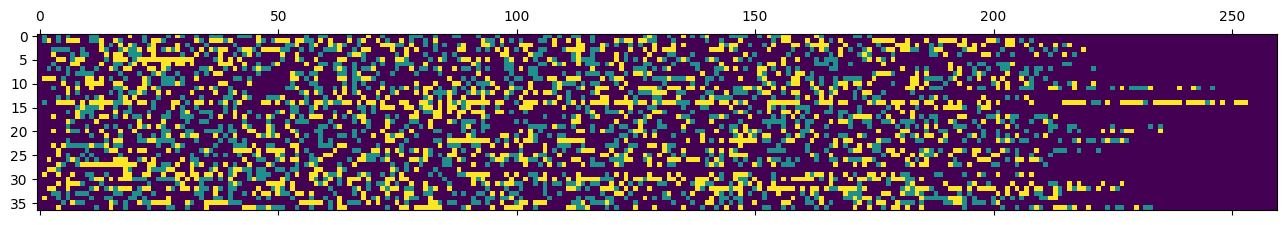

In [144]:
from matplotlib.pyplot import matshow
matshow(A_hs, aspect = 'auto')

In [145]:
np.save("heartsteps_mask", A_hs)
np.save("heartsteps_data", M_hs)

## Unused code

In [ ]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
  display(df_merged_cut[df_merged_cut['user.index'] == 4].iloc[1600:1680])


In [161]:
idx = df_merged.index.get_indexer_for(df_merged[pd.notna(df_merged["avail"])].index)
trial = df_merged.iloc[idx].reset_index(drop = True)
trial

,steps.utime,user.index,steps,decision.index.nogap,sugg.select.utime,sugg.decision.utime,sugg.select.slot,avail,send,send.active,send.sedentary
0,2015-07-22 16:35:00,1,0.0,0.0,2015-07-22 16:30:00,2015-07-22 16:31:53,2.0,True,True,False,True
1,2015-07-22 18:35:00,1,142.0,1.0,2015-07-22 18:30:00,2015-07-22 18:32:10,3.0,True,True,True,False
2,2015-07-22 21:35:00,1,70.0,2.0,2015-07-22 21:30:00,2015-07-22 21:31:48,4.0,True,False,False,False
3,2015-07-22 23:35:00,1,195.0,3.0,2015-07-22 23:30:00,2015-07-22 23:31:50,5.0,True,True,False,True
4,2015-07-23 09:35:00,1,0.0,4.0,2015-07-23 09:30:00,2015-07-23 09:31:31,1.0,True,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...
8155,2016-01-26 00:05:00,37,40.0,225.0,2016-01-26 00:02:00,2016-01-26 00:03:36,5.0,True,False,False,False
8156,2016-01-26 13:05:00,37,0.0,226.0,2016-01-26 13:00:00,2016-01-26 13:01:04,1.0,False,False,False,False
8157,2016-01-26 16:30:00,37,0.0,227.0,2016-01-26 16:26:00,2016-01-26 16:27:50,2.0,True,True,True,False
8158,2016-01-26 19:05:00,37,0.0,228.0,2016-01-26 19:00:00,2016-01-26 19:02:09,3.0,True,True,False,True


In [173]:
trial_sel = trial[["user.index", "decision.index.nogap", "sugg.select.utime", "sugg.decision.utime", "sugg.select.slot", "avail", "send", "send.active", "send.sedentary"]]
trial_sel

,user.index,decision.index.nogap,sugg.select.utime,sugg.decision.utime,sugg.select.slot,avail,send,send.active,send.sedentary
0,1,0.0,2015-07-22 16:30:00,2015-07-22 16:31:53,2.0,True,True,False,True
1,1,1.0,2015-07-22 18:30:00,2015-07-22 18:32:10,3.0,True,True,True,False
2,1,2.0,2015-07-22 21:30:00,2015-07-22 21:31:48,4.0,True,False,False,False
3,1,3.0,2015-07-22 23:30:00,2015-07-22 23:31:50,5.0,True,True,False,True
4,1,4.0,2015-07-23 09:30:00,2015-07-23 09:31:31,1.0,True,False,False,False
...,...,...,...,...,...,...,...,...,...
8155,37,225.0,2016-01-26 00:02:00,2016-01-26 00:03:36,5.0,True,False,False,False
8156,37,226.0,2016-01-26 13:00:00,2016-01-26 13:01:04,1.0,False,False,False,False
8157,37,227.0,2016-01-26 16:26:00,2016-01-26 16:27:50,2.0,True,True,True,False
8158,37,228.0,2016-01-26 19:00:00,2016-01-26 19:02:09,3.0,True,True,False,True


In [163]:
# df_sugg_sel

,user.index,decision.index.nogap,sugg.select.utime,sugg.decision.utime,sugg.select.slot,avail,send,send.active,send.sedentary
0,1,0.0,2015-07-22 16:30:00,2015-07-22 16:31:53,2,True,True,False,True
1,1,1.0,2015-07-22 18:30:00,2015-07-22 18:32:10,3,True,True,True,False
2,1,2.0,2015-07-22 21:30:00,2015-07-22 21:31:48,4,True,False,False,False
3,1,3.0,2015-07-22 23:30:00,2015-07-22 23:31:50,5,True,True,False,True
4,1,4.0,2015-07-23 09:30:00,2015-07-23 09:31:31,1,True,False,False,False
...,...,...,...,...,...,...,...,...,...
8269,37,225.0,2016-01-26 00:02:00,2016-01-26 00:03:36,5,True,False,False,False
8270,37,226.0,2016-01-26 13:00:00,2016-01-26 13:01:04,1,False,False,False,False
8271,37,227.0,2016-01-26 16:26:00,2016-01-26 16:27:50,2,True,True,True,False
8272,37,228.0,2016-01-26 19:00:00,2016-01-26 19:02:09,3,True,True,False,True


In [164]:
# out = pd.merge(trial_sel, df_sugg_sel, on=['user.index', 'sugg.select.utime'], how='outer',
#                suffixes=('_df1', '_df2')).set_index(['user.index', 'sugg.select.utime'])

# out.columns = pd.MultiIndex.from_tuples(out.columns.str.split('_').map(tuple)) \
#                            .swaplevel()

# out = out['df1'].compare(out['df2'])

out

decision.index.nogap         \
                                               self  other   
user.index sugg.select.utime                                 
13         2015-10-08 23:00:00                  NaN  188.0   
           2015-10-09 13:00:00                  NaN  189.0   
29         2015-12-23 01:30:00                  NaN   93.0   
           2015-12-23 13:00:00                  NaN   94.0   
           2015-12-23 17:40:00                  NaN   95.0   
...                                             ...    ...   
           2016-01-14 19:30:00                  NaN  206.0   
           2016-01-14 22:00:00                  NaN  207.0   
           2016-01-15 01:30:00                  NaN  208.0   
           2016-01-15 13:00:00                  NaN  209.0   
           2016-01-15 17:40:00                  NaN  210.0   

                               sugg.decision.utime                      \
                                              self               other   
user.index sugg.select.utime                                             
13         2015-10-08 23:00:00                 NaT 2015-10-09 00:02:03   
           2015-10-09 13:00:00                 NaT 2015-10-09 14:01:33   
29         2015-12-23 01:30:00                 NaT 2015-12-23 01:32:01   
           2015-12-23 13:00:00                 NaT 2015-12-23 13:02:23   
           2015-12-23 17:40:00                 NaT 2015-12-23 17:42:48   
...                                            ...                 ...   
           2016-01-14 19:30:00                 NaT 2016-01-14 19:31:32   
           2016-01-14 22:00:00                 NaT 2016-01-14 22:01:33   
           2016-01-15 01:30:00                 NaT 2016-01-15 01:31:38   
           2016-01-15 13:00:00                 NaT 2016-01-15 13:02:11   
           2016-01-15 17:40:00                 NaT 2016-01-15 17:41:31   

                               sugg.select.slot       avail       send         \
                                           self other  self other self  other   
user.index sugg.select.utime                                                    
13         2015-10-08 23:00:00              NaN   5.0   NaN  True  NaN   True   
           2015-10-09 13:00:00              NaN   1.0   NaN  True  NaN   True   
29         2015-12-23 01:30:00              NaN   5.0   NaN  True  NaN   True   
           2015-12-23 13:00:00              NaN   1.0   NaN  True  NaN  False   
           2015-12-23 17:40:00              NaN   2.0   NaN  True  NaN   True   
...                                         ...   ...   ...   ...  ...    ...   
           2016-01-14 19:30:00              NaN   3.0   NaN  True  NaN   True   
           2016-01-14 22:00:00              NaN   4.0   NaN  True  NaN   True   
           2016-01-15 01:30:00              NaN   5.0   NaN  True  NaN  False   
           2016-01-15 13:00:00              NaN   1.0   NaN  True  NaN   True   
           2016-01-15 17:40:00              NaN   2.0   NaN  True  NaN   True   

                               send.active        send.sedentary         
                                      self  other           self  other  
user.index sugg.select.utime                                             
13         2015-10-08 23:00:00         NaN   True            NaN  False  
           2015-10-09 13:00:00         NaN   True            NaN  False  
29         2015-12-23 01:30:00         NaN  False            NaN   True  
           2015-12-23 13:00:00         NaN  False            NaN  False  
           2015-12-23 17:40:00         NaN  False            NaN   True  
...                                    ...    ...            ...    ...  
           2016-01-14 19:30:00         NaN   True            NaN  False  
           2016-01-14 22:00:00         NaN   True            NaN  False  
           2016-01-15 01:30:00         NaN  False            NaN  False  
           2016-01-15 13:00:00         NaN  False            NaN   True  
           2016-01-15 17:40: